In [2]:
pip install torch

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/share/apps/python/3.8.6/intel/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install torchvision


Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/share/apps/python/3.8.6/intel/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import DataLoader
import torch.nn.functional as F

In [5]:
class BasicBlock(nn.Module):

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out



class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def project1_model():
    return ResNet(BasicBlock, [2, 2, 2, 2])

In [7]:
Transform =  transforms.Compose([
    transforms.Pad(4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
    transforms.ToTensor()])
trainingdata = torchvision.datasets.CIFAR10(root='./ data', train=True, download=True, transform=Transform) 
testdata = torchvision.datasets.CIFAR10(root='./data',  train=False, download=True, transform=Transform)

Files already downloaded and verified
Files already downloaded and verified


In [8]:
trainDataLoader = DataLoader(trainingdata, batch_size= 64, shuffle=True,num_workers=2)
testDataLoader = DataLoader(testdata, batch_size= 64, shuffle=False,num_workers=2)

In [9]:
model=project1_model()
Loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if torch.cuda.is_available():
    model.cuda()

In [10]:
train_loss_history = []
test_loss_history = []
train_acc_history = [] 
test_acc_history = [] 


for epoch in range(10):
    train_loss = 0.0
    test_loss = 0.0
    correct_points_train = 0 
    correct_points_test = 0 
    for i, data in enumerate(trainDataLoader):
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        predicted_output = model(images)
        fit = Loss(predicted_output,labels)
        optimizer.zero_grad()
        fit.backward()
        optimizer.step()
        train_loss += fit.item()
        correct_points_train +=  (torch.eq(torch.max(predicted_output, 1)[1],labels).sum()).data.cpu().numpy()
    for i, data in enumerate(testDataLoader):
        with torch.no_grad():
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            predicted_output = model(images)
            fit = Loss(predicted_output,labels)
            test_loss += fit.item()
            correct_points_test +=  (torch.eq(torch.max(predicted_output, 1) [1],labels).sum()).data.cpu().numpy() 
            
    train_loss = train_loss/len(trainDataLoader)
    test_loss = test_loss/len(testDataLoader)
    
    train_loss_history.append(train_loss)
    test_loss_history.append(test_loss)
    
    train_acc = correct_points_train/len(trainDataLoader) 
    test_acc = correct_points_test/len(testDataLoader) 
    
    train_acc_history.append(train_acc) 
    test_acc_history.append(test_acc)

    print('Epoch %s, Train loss %s, Test loss %s Train accuracy %s Test accuracy  %s'%(epoch, train_loss, test_loss, train_acc, test_acc))
    print("Accuracy:", (torch.eq(torch.max(predicted_output, 1)[1],labels).sum()/len(labels)*100).data.cpu().numpy())

Epoch 0, Train loss 1.5235785185680975, Test loss 1.2343593368864363 Train accuracy 27.923273657289002 Test accuracy  35.11464968152866
Accuracy: 50.0
Epoch 1, Train loss 1.0676222985510326, Test loss 0.9465824547846606 Train accuracy 39.54347826086956 Test accuracy  42.17197452229299
Accuracy: 37.5
Epoch 2, Train loss 0.8374244611510231, Test loss 0.7610474414886184 Train accuracy 45.03580562659847 Test accuracy  47.02547770700637
Accuracy: 68.75
Epoch 3, Train loss 0.7076059749440464, Test loss 0.6993804120334091 Train accuracy 48.13682864450128 Test accuracy  48.01910828025478
Accuracy: 62.5
Epoch 4, Train loss 0.6184499604470285, Test loss 0.6172527896750505 Train accuracy 50.18158567774936 Test accuracy  50.01273885350319
Accuracy: 75.0
Epoch 5, Train loss 0.5552821730065833, Test loss 0.5949854621082354 Train accuracy 51.5460358056266 Test accuracy  50.59872611464968
Accuracy: 87.5
Epoch 6, Train loss 0.504957031277592, Test loss 0.5306184251976621 Train accuracy 52.7698209718670

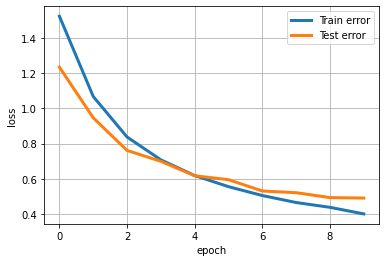

In [11]:
#import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(range(10),train_loss_history,'-',linewidth=3,label='Train error')
plt.plot(range(10),test_loss_history,'-',linewidth=3,label='Test error')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()